In [442]:
import os
import re
import glob
import scipy
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

% matplotlib inline

from __future__ import division
init_notebook_mode(connected=True)

matplotlib.rc('axes', labelsize = 6)
matplotlib.rc('xtick', labelsize = 5) 
matplotlib.rc('ytick', labelsize = 5) 

#### Load order parameters

In [257]:
class OP_Data:
    
    def __init__(self, icR, ilR):
        self.icR = int(icR)
        self.ilR = int(ilR)
        self.nRs = 0
        self.feats = collections.defaultdict(list)
        
    def describe(self):
        print "icR: " + repr(self.icR) + " ilR: " + repr(self.ilR) + " nRs: " + repr(self.nRs)
        
    def add_rep_feats(self, nRep, df):
        self.nRs += 1
        if nRep == self.nRs:
            self.feats[self.nRs] = df.as_matrix()
        else:
            print "Error: Replicate data entered out of order!"
    
    def get_rep_feat(self, nRep):
        return self.feats[nRep]
    
    def get_sim_params(self):
        return (self.icR, self.ilR)
    
    def get_nreps(self):
        return self.nRs

In [258]:
OP_Data_List = list()

for subdir in glob.glob(order_param_dir + "/*/"):
    
    foldername = subdir.split(os.sep)[1]
    icR = foldername.split('_')[2]
    ilR = foldername.split('_')[-1]
    OP_Data_List.append(OP_Data(icR, ilR))

    csvfilelist = glob.glob(order_param_dir + os.sep + foldername + os.sep + "*.csv")
    csvfilenames = [os.path.basename(csvfilename) for csvfilename in csvfilelist]
    csvfilenames.sort(key = lambda f: int(filter(str.isdigit, f)))
    
    for csvfilename in csvfilenames:
        df = pd.read_csv(order_param_dir + os.sep + foldername + os.sep + csvfilename, header=None)
        re_cap = re.match(".*_iR_(\d+)_.*.csv", csvfilename)
        nRep = int(re_cap.group(1))
        OP_Data_List[-1].add_rep_feats(nRep, df)
    
    OP_Data_List[-1].describe()

icR: 1 ilR: 3 nRs: 100
icR: 2 ilR: 3 nRs: 100
icR: 5 ilR: 4 nRs: 100
icR: 4 ilR: 4 nRs: 100
icR: 2 ilR: 2 nRs: 100
icR: 4 ilR: 1 nRs: 100
icR: 1 ilR: 1 nRs: 100
icR: 1 ilR: 2 nRs: 100
icR: 2 ilR: 4 nRs: 100
icR: 2 ilR: 1 nRs: 100
icR: 5 ilR: 1 nRs: 100
icR: 3 ilR: 5 nRs: 100
icR: 4 ilR: 3 nRs: 100
icR: 3 ilR: 3 nRs: 100
icR: 1 ilR: 5 nRs: 100
icR: 4 ilR: 2 nRs: 100
icR: 3 ilR: 4 nRs: 100
icR: 2 ilR: 5 nRs: 100
icR: 1 ilR: 4 nRs: 100
icR: 5 ilR: 3 nRs: 100
icR: 5 ilR: 2 nRs: 100
icR: 5 ilR: 5 nRs: 100
icR: 3 ilR: 1 nRs: 100
icR: 4 ilR: 5 nRs: 100
icR: 3 ilR: 2 nRs: 100


#### Extract and plot features

In [259]:
def extract_feats(OP_List, icR, ilR, nRep):
    for OP_Data in OP_List:
        if (icR, ilR) == OP_Data.get_sim_params():
            feat_data = np.transpose(OP_Data.get_rep_feat(nRep))
            time = feat_data[0]
            pol = feat_data[1]
            ang_mmt = feat_data[2]
            abs_ang_mmt = feat_data[3]
            mean_nnd = feat_data[4]
            return (time, pol, ang_mmt, abs_ang_mmt, mean_nnd)

In [260]:
def plot_feats(time, pol, ang_mmt, abs_ang_mmt, mean_nnd):
    plt.figure(figsize=(4,2), dpi = 300)
    plt.plot(time, pol, 'b-', label="Polarization", linewidth=0.8)
    plt.plot(time, ang_mmt, 'g-', label="Angular Momentum", linewidth=0.8)
    plt.plot(time, abs_ang_mmt, 'r-', label="Absolute Angular Momentum", linewidth=0.8)
    plt.plot(time, mean_nnd, 'k-', label="Mean Nearest Neighbor Distance", linewidth=0.8)
    plt.legend(loc=4, prop={'size': 4})
    plt.tight_layout()
    plt.xlabel("Time")
    plt.ylabel("Order Parameters")
    plt.show()

In [261]:
def plot_all_reps(OP_Data_List, icR, ilR):
    plt.figure(figsize=(4,2), dpi = 300)
    for OP_Data in OP_Data_List:
        if (icR, ilR) == OP_Data.get_sim_params():
            nReps = OP_Data.get_nreps()
            for rep in range(1, nReps+1):
                feat_data = np.transpose(OP_Data.get_rep_feat(rep))
                l0, = plt.plot(feat_data[0], feat_data[1], 'b-', label="Polarization", linewidth=0.5, alpha=0.2)
                l1, = plt.plot(feat_data[0], feat_data[2], 'g-', label="Angular Momentum", linewidth=0.5, alpha=0.2)
                l2, = plt.plot(feat_data[0], feat_data[3], 'r-', label="Angular Momentum", linewidth=0.5, alpha=0.2)
                l3, = plt.plot(feat_data[0], feat_data[4], 'k-', label="Angular Momentum", linewidth=0.5, alpha=0.2)
    lgd_labels = ["Polarization", "Angular Momentum", "Abs. Angular Momentum", "Mean Neighbor Distance"]
    plt.legend([l0, l1, l2, l3], lgd_labels, loc=4, prop={'size': 4})
    plt.tight_layout()
    plt.xlabel("Time")
    plt.ylabel("Order Parameters")
    plt.show()

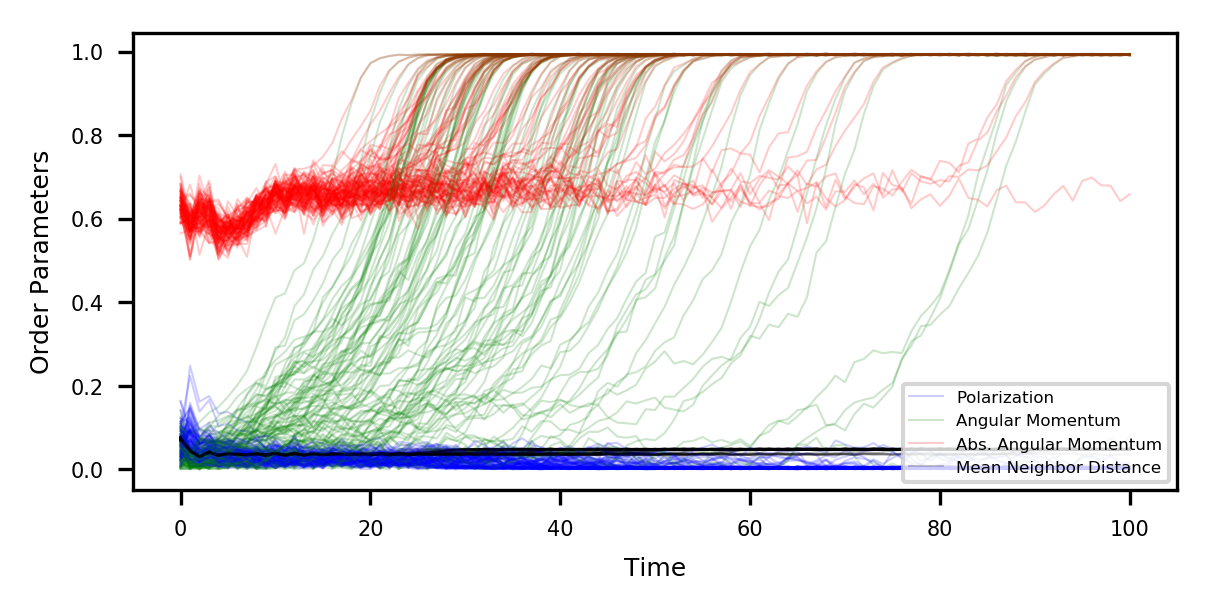

In [262]:
# Plot single replicate:
# (time, pol, ang_mmt, abs_ang_mmt, mean_nnd) = extract_feats(OP_Data_List, 2, 3, 3)
# plot_feats(time, pol, ang_mmt, abs_ang_mmt, mean_nnd)

# Plot all replicates:
plot_all_reps(OP_Data_List, 4, 1)

#### Compute feature vector

In [280]:
def construct_feat_vector(OP_Data_List, icR, ilR, nRep, nSamples):
    for OP_Data in OP_Data_List:
        if (icR, ilR) == OP_Data.get_sim_params():
            feat_data = np.transpose(OP_Data.get_rep_feat(nRep))
            max_time = np.max(feat_data[0])
            tpoints = np.linspace(0, max_time, nSamples)
            tpoints = np.unique([int(tp) for tp in tpoints])
            if len(tpoints) != nSamples:
                print "Error: Number of samples requested exceed number of time points"
                return None
            pol = [feat_data[1][idx] for idx in tpoints]
            ang_mmt = [feat_data[2][idx] for idx in tpoints]
            abs_ang_mmt = [feat_data[3][idx] for idx in tpoints]
            mean_nnd = [feat_data[4][idx] for idx in tpoints]
            interleave_feats = [pol, ang_mmt, abs_ang_mmt, mean_nnd]
            return [val for tup in zip(*interleave_feats) for val in tup]

In [290]:
num_sims = 5*5
num_tpoints = 50
num_replicates = 100
feat_vec_size = num_samples * 4

feat_mat = np.empty((num_sims*num_replicates, feat_vec_size))
target = np.empty((num_sims*num_replicates, 2))

ind = 0
for icR in range(1, 5+1):
    for ilR in range(1, 5+1):
        for rep in range(1, num_replicates+1):
            feat_mat[ind, :] = construct_feat_vector(OP_Data_List, icR, ilR, rep, num_tpoints)
            target[ind, :] = [icR, ilR]
            ind += 1

#### Classify features

In [307]:
scaler = StandardScaler()
print scaler.fit(feat_mat)
feat_mat_std = scaler.transform(feat_mat)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [338]:
np.save('standardized_features.npy', feat_mat_std)
np.save('targets.npy', target)

([], <a list of 0 Text yticklabel objects>)

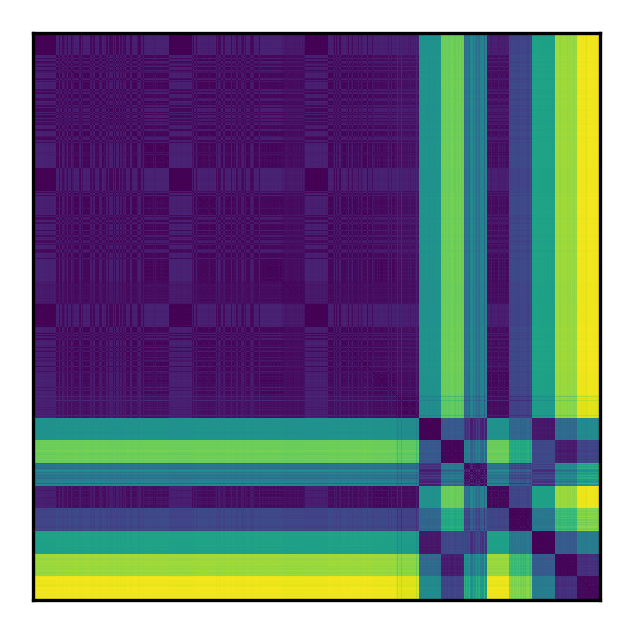

In [453]:
distances = scipy.spatial.distance.pdist(feat_mat, 'euclidean')
dist_mat = scipy.spatial.distance.squareform(distances)

plt.figure(figsize=(2.5,2.5), dpi=300)
plt.imshow(dist_mat)
plt.xticks([])
plt.yticks([])

#### PCA

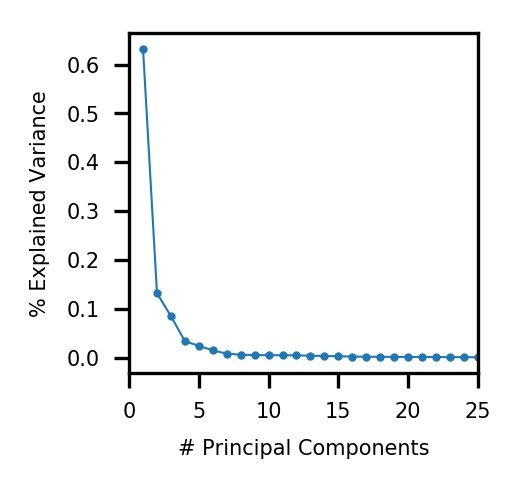

In [320]:
(num_rows, num_feat) = np.shape(feat_mat)

pca_model = PCA(n_components = num_feat)
pca_model.fit_transform(feat_mat_std)
nc = np.linspace(1, num_feat, num_feat)

plt.figure(figsize=(1.5,1.5), dpi=300)
plt.plot(nc, pca_model.explained_variance_ratio_, '-o', markersize=1, linewidth=0.5)

plt.xlabel("# Principal Components", fontsize=5)
plt.ylabel("% Explained Variance", fontsize=5)
plt.xlim([0, 25])
plt.show()

In [438]:
pca = PCA(n_components = 3)
pca.fit(feat_mat_std)
Y = pca.transform(feat_mat_std)

plt_data = []

param_cnt = 0
for icR_val in range(1, 5+1):
    for ilR_val in range(1, 5+1):
        target_idx = list()
        cnt = 0
        for x in zip(np.array(target == [icR_val, ilR_val]).tolist()):
            if x[0] == [True, True]:
                target_idx.append(cnt)
            cnt += 1
            
        trace = go.Scatter3d(
            name = "icR: " + repr(icR_val) + " ilR: " + repr(ilR_val),
            x = Y[target_idx, 0],
            y = Y[target_idx, 1],
            z = Y[target_idx, 2],
            mode = 'markers',
            marker = dict(
                color = param_cnt,
                size = 8,
                symbol = 'circle',
                line = dict(
                    color = 'rgb(180, 180, 180)',
                    width = 1.0
                ),
                opacity = 0.4
            )
        )
        plt_data.append(trace)
        param_cnt += 1
        
layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

#### t-SNE

In [441]:
(num_rows, num_feat) = np.shape(feat_mat_std)

tsne = TSNE(n_components=3, random_state=0, init='random', perplexity=50)
np.set_printoptions(suppress=True)
Y_tsne = tsne.fit_transform(feat_mat_std)

plt_data = []

param_cnt = 0
for icR_val in range(1, 5+1):
    for ilR_val in range(1, 5+1):
        target_idx = list()
        cnt = 0
        for x in zip(np.array(target == [icR_val, ilR_val]).tolist()):
            if x[0] == [True, True]:
                target_idx.append(cnt)
            cnt += 1
            
        trace = go.Scatter3d(
            name = "icR: " + repr(icR_val) + " ilR: " + repr(ilR_val),
            x = Y_tsne[target_idx, 0],
            y = Y_tsne[target_idx, 1],
            z = Y_tsne[target_idx, 2],
            mode = 'markers',
            marker = dict(
                color = param_cnt,
                size = 8,
                symbol = 'circle',
                line = dict(
                    color = 'rgb(180, 180, 180)',
                    width = 1.0
                ),
                opacity = 0.4
            )
        )
        plt_data.append(trace)
        param_cnt += 1
        
layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)